In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import collections
import ast
import sys
sys.path.append('..')
from modules import utils, constants
from pyvis.network import Network
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
%matplotlib inline

#### The functions

In [3]:
def generate_tuple_dict(df):
    frequency_dict = {}
    for traj in df.trajectory:
        if traj in frequency_dict.keys():
            frequency_dict[traj] += 1
        else:
            frequency_dict[traj] = 1
    streamlined_frequency_dict = streamline_frequency_dict(frequency_dict)
    overall_tup_dict = {}
    for key, value in streamlined_frequency_dict.items():
#     for key, value in frequency_dict.items():
        new_key = ast.literal_eval(key)
        for tup in zip(new_key, new_key[1:]):
            #print(f'tup: {tup}')
            if tup in overall_tup_dict.keys():
                overall_tup_dict[tup] += value
            else:
                overall_tup_dict[tup] = value
    #print(f'overall_tup_dict: {overall_tup_dict}')
    return overall_tup_dict

In [4]:
def streamline_frequency_dict(frequency_dict):
    frequency_dict_list = [] #will hold dictonaries with 2 keys i.e. 'set' and 'value'
    for path_dict, value in frequency_dict.items():
        all_set_list = [i['set'] for i in frequency_dict_list] #get all the sets so far in the list 
        path_set = set(ast.literal_eval(path_dict)) #get the set of current path dict to check if its already in list
        if path_set in all_set_list: #increase value else insert it - work on this!!!!!!!!!!!!!!!
            for elem in frequency_dict_list: #look for if path_set is already in frequency_dict_list 
                if elem['set'] == path_set: #find the matching path_set in the frequency_dict_list
                    elem['value'] += value #increase the value for that set
        else:
            frequency_dict_list.append({'set':path_set, 'value':value}) #introdue the new set in the list
    
    all_list = [list(path_dict['set']) for path_dict in frequency_dict_list] # list of all the set(pathways)
    flat_list = [item for sublist in all_list for item in sublist] #flatten list to get commonest items
    commonest_elements = dict(collections.Counter(flat_list)) #the most frequent items in the list
    commonest_elements = {k: v for k, v in sorted(commonest_elements.items(), reverse=True, key=lambda item: item[1])}
    commonest_elements_list = list(commonest_elements.keys())
    commonest_elements_list = [i for i in commonest_elements_list if i not in ['Lupus', 'No lupus', 'Inconclusive diagnosis']] + ['Lupus', 'No lupus', 'Inconclusive diagnosis']
    
    for item in frequency_dict_list:
        item['set'] = sorted(list(item['set']), key=lambda x: commonest_elements_list.index(x))
    
    keys = [str(i['set']) for i in frequency_dict_list]
    values = [i['value'] for i in frequency_dict_list]
    final_frequency_dict = {k:v for (k,v) in zip(keys, values)}
    
    return final_frequency_dict

In [5]:
def create_sankey_df(df):
    overall_tup_dict = generate_tuple_dict(df)
    sankey_df = pd.DataFrame()
    sankey_df['source'] = [i[0] for i in overall_tup_dict.keys()]
    sankey_df['target'] = [i[1] for i in overall_tup_dict.keys()]
    sankey_df['value'] = list(overall_tup_dict.values())
    sankey_df['link_type'] = sankey_df['target'].apply(lambda i: 'terminal' if i in ['No lupus', 'Lupus', 'Inconclusive diagnosis'] else 'non_terminal')
    return sankey_df

In [6]:
def get_threshold_value(row):
    substring = f"'{row.source}', '{row.target}'"
    substring_df = pd.DataFrame()
    for i, test_row in test_df.iterrows():
        if substring in test_row.trajectory:
            substring_df = substring_df.append(test_row)
    substring_testing_df = testing_df.loc[substring_df.index]
    
    threshold_values = substring_testing_df[row.source].unique().tolist()
    if len(threshold_values) == 1:
        return int(threshold_values[0])
    else:
#         print(f'There is {len(threshold_values)} threshold values for the edge between {row.source} and {row.target}')
        return str(threshold_values)

In [7]:
def draw_pyvis_network(pathways_df):
#     pathways_df = create_sankey_df(test_df)
    pathways_df['type'] = 'directed'
#     start_node = 'No lupus'
    got_net = Network(notebook=True, height='750px', width='100%', directed=True, cdn_resources='in_line')
    got_net.add_node(start_node, color='purple', size=20)
    got_net.add_nodes(non_terminal_nodes, size=[15]*len(non_terminal_nodes), color=['blue']*len(non_terminal_nodes))
    got_net.add_nodes(terminal_nodes, color=['green']*len(terminal_nodes), size=[20]*len(terminal_nodes))
    for src, target, value in zip(pathways_df.source, pathways_df.target, pathways_df.value):
        if value > threshold:
            got_net.add_edge(src, target, value=value, color='red')
        else:
            got_net.add_edge(src, target, value=value, color='blue')
    return got_net

In [8]:
def draw_labelled_pyvis_network(pathways_df, pathway_type='network'): #second type is trajectory 
    pathways_df['type'] = 'directed'
    pathways_df['edge_threshold'] = pathways_df.apply(lambda row: get_threshold_value(row), axis=1)
    
    #change get_net to something else since it satnds for Game of Thrones
    got_net = Network(notebook=True, height='750px', width='100%', directed=True, cdn_resources='in_line')
    got_net.add_node(start_node, color='purple', size=20)
    got_net.add_nodes(non_terminal_nodes, size=[15]*len(non_terminal_nodes), color=['blue']*len(non_terminal_nodes))
    got_net.add_nodes(terminal_nodes, color=['green']*len(terminal_nodes), size=[20]*len(terminal_nodes))
    for src, target, value, edge_thresh in zip(pathways_df.source, pathways_df.target, pathways_df.value, pathways_df.edge_threshold):
        if value > threshold: #this is what mainly changes
            if isinstance(edge_thresh, str):
                got_net.add_edge(src, target, value=value, color='red', label=edge_thresh)
            else:
                got_net.add_edge(src, target, value=value, color='red', label=str(int(edge_thresh)))
        else:
            got_net.add_edge(src, target, value=value, color='blue')
#         elif pathway_type =='trajectory': #It's just one trajectory
#             if math.isnan(edge_thresh):
#                 got_net.add_edge(src, target, value=value, color='blue')
#             else:
#                 got_net.add_edge(src, target, value=value, color='blue', label=str(int(edge_thresh)))
#         else:
#             print('Unknown pathway type')
    return got_net
#     return pathways_df

#### The data

In [9]:
testing_df = pd.read_csv('../data/test_set_constant.csv')
testing_df.head()

,ana,fever,leukopenia,thrombocytopenia,auto_immune_hemolysis,delirium,psychosis,seizure,non_scarring_alopecia,oral_ulcers,...,joint_involvement,proteinuria,anti_cardioliphin_antibodies,anti_β2gp1_antibodies,lupus_anti_coagulant,low_c3,low_c4,anti_dsdna_antibody,anti_smith_antibody,label
0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,1,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
2,1,0,0,0,0,0,1,0,0,0,...,1,0,0,0,1,1,0,0,0,1
3,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,1
4,1,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,1


In [10]:
model_name = 'dueling_dqn_per'
seed = 84
steps = int(10e7)

In [11]:
test_df = pd.read_csv(f'../test_dfs/{model_name}_risk_factor_{seed}_{steps}.csv')
test_df.head()

,index,episode_length,reward,y_pred,y_actual,trajectory,terminated,is_success
0,0.0,12.0,0.564819,1.0,1.0,"['ana', 'joint_involvement', 'anti_dsdna_antib...",0.0,1.0
1,1.0,13.0,0.501479,1.0,1.0,"['ana', 'joint_involvement', 'anti_dsdna_antib...",0.0,1.0
2,2.0,12.0,0.540303,1.0,1.0,"['ana', 'joint_involvement', 'anti_dsdna_antib...",0.0,1.0
3,3.0,10.0,0.646010,1.0,1.0,"['ana', 'joint_involvement', 'anti_dsdna_antib...",0.0,1.0
4,4.0,10.0,0.649264,1.0,1.0,"['ana', 'joint_involvement', 'anti_dsdna_antib...",0.0,1.0


In [12]:
threshold = 0.1*len(test_df)
threshold

1400.0

In [13]:
acc, f1, roc_auc = utils.test(test_df.y_actual, test_df.y_pred)
acc

98.95714285714286

#### The magic happens

In [14]:
pathways_df = create_sankey_df(test_df)
pathways_df.head()

,source,target,value,link_type
0,ana,joint_involvement,14000,non_terminal
1,joint_involvement,low_c3,13918,non_terminal
2,low_c3,anti_dsdna_antibody,10459,non_terminal
3,anti_dsdna_antibody,psychosis,10172,non_terminal
4,psychosis,fever,9512,non_terminal


In [15]:
start_node = pathways_df.iloc[0]['source']
all_nodes = list(set(pathways_df.source.unique().tolist() + pathways_df.target.unique().tolist()))
terminal_nodes = list(set(pathways_df[pathways_df.link_type=='terminal'].target))
non_terminal_nodes = [i for i in all_nodes if i not in terminal_nodes and i!=start_node]

In [16]:
terminal_nodes

['Lupus', 'No lupus']

In [17]:
got_net = draw_pyvis_network(pathways_df)    
got_net.show('Example.html')

Example.html


#### Labelled network

In [17]:
labelled_got_net = draw_labelled_pyvis_network(pathways_df)    
labelled_got_net.show('Example.html')

Example.html


#### The confusion matrix

In [31]:
def plot_confusion_matrix(y_actual, y_pred, save=False, filename=False):
    '''
    Plots a confusion matrix of a model's results
    '''
    cm = confusion_matrix(y_actual, y_pred)
    # cm_df = pd.DataFrame(cm, index = constants.CLASS_DICT.keys(), columns = constants.CLASS_DICT.keys())
    cm_df = pd.DataFrame(cm, index=['No lupus', 'Lupus'], columns=['No lupus', 'Lupus'])
    plt.figure(figsize=(6, 4))
    ax = sns.heatmap(cm_df, annot=True)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Anemia')
    plt.xlabel('Predicted Anemia')
    plt.tight_layout()
    if save:
        plt.savefig(filename)
    plt.show()
    plt.close()

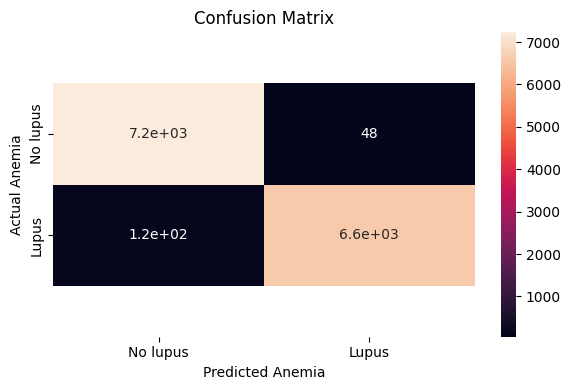

In [32]:
cm = plot_confusion_matrix(test_df['y_actual'], test_df['y_pred'])
cm

In [ ]:
utils.plot_classification_report(test_df['y_actual'], test_df['y_pred'])